<a href="https://colab.research.google.com/github/ZerocoderUniversity/AI-course-prompt-engineering/blob/main/09Project_ai_jewelry_consultant/%D0%98%D0%98_%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82_%D0%B4%D0%BB%D1%8F_%D1%8E%D0%B2%D0%B5%D0%BB%D0%B8%D1%80%D0%BD%D1%8B%D1%85_%D0%B8%D0%B7%D0%B4%D0%B5%D0%BB%D0%B8%D0%B9_RAG_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Построение RAG-системы для вашего проекта

**Цель:** создать виртуального консультанта, который может отвечать на вопросы клиентов, предоставлять консультации по уходу за ювелирными изделиями, описаниям материалов, а также помогать выбрать украшения на основе предпочтений клиента.

Для создания интеллектуального помощника для ювелирного магазина, который будет предоставлять не только общие ответы на вопросы, но и консультировать по более специфичной информации (например, по материалам, уходу за украшениями, определению стоимости, рекомендациям по выбору и т.д.), можно применить Retrieval-Augmented Generation (RAG). RAG — это подход, который сочетает генерацию текста и извлечение информации, позволяя эффективно отвечать на вопросы, используя как знания модели, так и внешние источники данных (например, базы данных).

В этом кратком руководстве мы создадим простую систему RAG с помощью LLM от Meta AI - Llama 3, в частности, IlyaGusev/saiga_llama3_8b, дообученная на русском языке, [ссылка](https://huggingface.co/IlyaGusev/saiga_llama3_8b) на Hugging Face Hub.


Для работы с неструктурированными данными будем использовать [Unstructured Serverless API](https://unstructured.io/)

Для выстраивания цепочки действий используем LangChain.
Также в качестве баз данных расссмотрим:
- FAISS для векторного хранилища
- ChromaDB

In [ ]:
!pip install -qU "unstructured-ingest[pdf]" unstructured langchain langchain-community transformers accelerate bitsandbytes sentence-transformers faiss-cpu

Для работы с файлами разного формата необходим API ключ - [Unstructured API key](https://unstructured.io/api-key-hosted)

In [ ]:
import os

os.environ["UNSTRUCTURED_API_KEY"] = ""
os.environ["UNSTRUCTURED_URL"] = ""

In [ ]:
from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.interfaces import ProcessorConfig
from unstructured_ingest.v2.processes.connectors.local import (
    LocalIndexerConfig,
    LocalDownloaderConfig,
    LocalConnectionConfig,
    LocalUploaderConfig
)
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig
from unstructured_ingest.v2.processes.chunker import ChunkerConfig

## Faiss

Создаем FAISS-векторное хранилище

**Описание:** FAISS — библиотека, предназначенная для эффективного поиска и кластеризации в больших векторных наборах данных. Она оптимизирована для быстрого поиска ближайших соседей (nearest neighbor search, NNS).

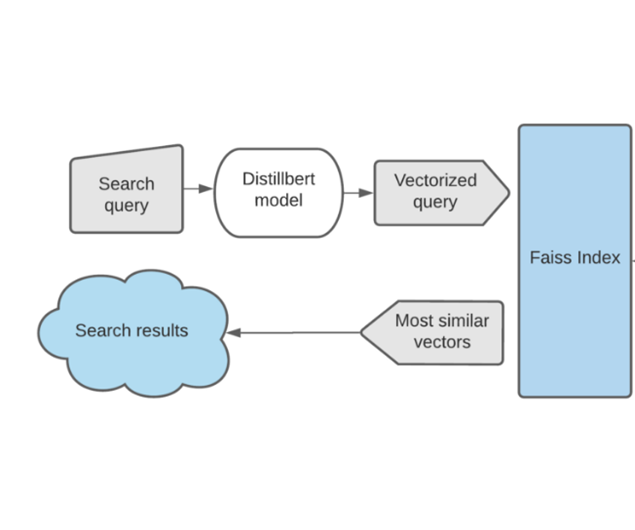

### Парсинг входных документов

In [ ]:
mkdir data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
mkdir output

In [ ]:
directory_with_pdfs="/content/data"
directory_with_results="/content/output"

Pipeline.from_configs(
    context=ProcessorConfig(),
    indexer_config=LocalIndexerConfig(input_path=directory_with_pdfs),
    downloader_config=LocalDownloaderConfig(),
    source_connection_config=LocalConnectionConfig(),
    partitioner_config=PartitionerConfig(
        partition_by_api=True,
        api_key=os.getenv("UNSTRUCTURED_API_KEY"),
        partition_endpoint=os.getenv("UNSTRUCTURED_API_URL"),
        strategy="hi_res",
        additional_partition_args={
            "language": "rus",
            "split_pdf_page": True,
            "split_pdf_concurrency_level": 15,
            },
        ),
    uploader_config=LocalUploaderConfig(output_dir=directory_with_results)
).run()


Проведем декодировку текста

In [ ]:
from unstructured.staging.base import elements_from_json
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
import os

def decode_text(text):
    try:
        # Пробуем декодировать, если текст изначально закодирован
        if isinstance(text, bytes):
            return text.decode('utf-8')
        return text
    except (UnicodeDecodeError, AttributeError):
        return text

# Функция для загрузки файлов и декодирования текста
def load_processed_files(directory_path):
    elements = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            try:
                # Загружаем элементы из JSON
                file_elements = elements_from_json(filename=file_path)
                # Применяем декодирование текста для каждого элемента
                for element in file_elements:
                    if hasattr(element, "text") and element.text is not None:
                        element.text = decode_text(element.text)
                elements.extend(file_elements)
            except IOError:
                print(f"Error: Could not read file {filename}.")
    return elements

# Загружаем элементы с декодированным текстом
elements = load_processed_files(directory_with_results)

# Преобразуем элементы в объекты Document
documents = []
for element in elements:
    metadata = element.metadata.to_dict()
    documents.append(Document(page_content=element.text, metadata=metadata))

In [ ]:
db = FAISS.from_documents(documents, HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5"))
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 4})

Создадим вторую базу данных с информацией о товарах

In [ ]:
catalog = [
  {
    "name": "Кольцо с бриллиантом",
    "description": "Элегантное кольцо с высококачественным бриллиантом 0.5 карата.",
    "usage": "Идеально подходит для особых случаев, таких как помолвка или свадьба.",
    "price": "15000 руб.",
    "url": "https://example.com/product/1"
  },
  {
    "name": "Серебряные серьги с аметистами",
    "description": "Серьги из 925 стерлингового серебра с аметистами высшей пробы.",
    "usage": "Подходят для ежедневного ношения или торжественных мероприятий.",
    "price": "8000 руб.",
    "url": "https://example.com/product/2"
  },
  {
    "name": "Золотая подвеска с изумрудом",
    "description": "Изысканная подвеска из 14-каратного золота с натуральным изумрудом.",
    "usage": "Отлично смотрится как для повседневного, так и для вечернего образа.",
    "price": "22000 руб.",
    "url": "https://example.com/product/3"
  },
  {
    "name": "Браслет с цирконами",
    "description": "Тонкий браслет с вставками из искусственных цирконов.",
    "usage": "Подходит для праздничных случаев или в качестве стильного аксессуара.",
    "price": "3500 руб.",
    "url": "https://example.com/product/4"
  },
  {
    "name": "Серьги с жемчугом",
    "description": "Классические серьги с натуральным жемчугом и золотыми вставками.",
    "usage": "Идеально для повседневного ношения или для элегантных мероприятий.",
    "price": "10000 руб.",
    "url": "https://example.com/product/5"
  },
  {
    "name": "Часы с бриллиантами",
    "description": "Шикарные часы с инкрустацией из бриллиантов на циферблате.",
    "usage": "Для людей, ценящих изысканный стиль и точность.",
    "price": "50000 руб.",
    "url": "https://example.com/product/6"
  },
  {
    "name": "Кулон с топазом",
    "description": "Изящный кулон с натуральным топазом, украшенный серебряной оправой.",
    "usage": "Можно носить как на праздники, так и для ежедневного стиля.",
    "price": "7000 руб.",
    "url": "https://example.com/product/7"
  },
  {
    "name": "Золотые обручальные кольца",
    "description": "Пара золотых обручальных колец с матовой отделкой и гравировкой.",
    "usage": "Идеально для жениха и невесты в день свадьбы.",
    "price": "25000 руб.",
    "url": "https://example.com/product/8"
  },
  {
    "name": "Печатка с ониксом",
    "description": "Мужская печатка с ониксом и серебряной оправой.",
    "usage": "Для стильных мужчин, предпочитающих выразительные аксессуары.",
    "price": "12000 руб.",
    "url": "https://example.com/product/9"
  },
  {
    "name": "Колье с сапфирами",
    "description": "Роскошное колье с натуральными сапфирами и бриллиантами.",
    "usage": "Для особых случаев, таких как вечеринки или торжественные мероприятия.",
    "price": "45000 руб.",
    "url": "https://example.com/product/10"
  }
]



In [ ]:
import json
# Сохраняем данные в JSON файл
with open('catalog.json', 'w') as json_file:
    json.dump(catalog, json_file, indent=4)

In [ ]:
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# Пример загрузки каталога
with open("catalog.json", "r", encoding="utf-8") as f:
    catalog = json.load(f)

documents = []
for element in catalog:
    metadata = element
    documents.append(Document(page_content=element['description'], metadata=metadata))

catalog_db = FAISS.from_documents(documents, HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5"))
catalog_retriever = catalog_db.as_retriever(search_type="similarity", search_kwargs={"k": 4})

Сохранение и загрузка БД

In [ ]:
# Укажите путь для сохранения базы данных
save_path = "./faiss_index"

# Сохранение базы данных
db.save_local(save_path)


In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")
db = FAISS.load_local(save_path, embeddings, allow_dangerous_deserialization=True)

### Загрузка модели

In [ ]:
from huggingface_hub.hf_api import HfFolder

HfFolder.save_token("")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "IlyaGusev/saiga_llama3_8b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Посмотрим на генерация без RAG

In [ ]:
# Переводим модель в режим оценки
model.eval()
model.to("cuda")

# Функция для генерации текста
def generate_text(prompt, max_new_tokens=250):
    # Токенизируем ввод
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Генерация текста
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            max_new_tokens=max_new_tokens,  # Используем новый параметр
            num_beams=5,
            no_repeat_ngram_size=2,
            temperature=0.7,
            top_k=50,
            top_p=0.95,
            do_sample=True
        )

    # Декодируем сгенерированные токены в текст
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Пример запроса
prompt = "Привет! Расскажи о том как ухаживать за серебрянными украшениями"
generated_output = generate_text(prompt)
print(generated_output)

In [ ]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.5,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=700,
    eos_token_id=terminators,
)

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

prompt_template = """
<|start_header_id|>user<|end_header_id|>
Ты — умный ассистент, специализирующийся на ювелирных украшениях.
Ваши основные задачи:
1. Отвечать на вопросы о ювелирных украшениях, их характеристиках и ценах по следующему контексту {context}
2. Помогать клиентам в выборе подходящих товаров по следующему контексту {products}

Ваша цель — предоставлять полезные, понятные и дружелюбные ответы.
Если вы не знаете ответа, просто скажите: «Я не знаю». Не придумывайте информацию.
При предложении товаров старайтесь быть конкретным и описывать, как товар может помочь.
Если для ответа требуется больше информации, задавайте уточняющие вопросы.

Вопрос: {question}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

prompt = PromptTemplate(
    input_variables=[ "context", "products", "question",],
    template=prompt_template,
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def format_products(products):
    return "\n".join(
        f"Название: {doc.metadata['name']}\nОписание: {doc.page_content}\nЦена: {doc.metadata['price']}\nСсылка: {doc.metadata['url']}\n"
        for doc in products)


rag_chain = (
    {
        "context": retriever | format_docs,
        "products": catalog_retriever | format_products,
        "question": RunnablePassthrough(),

    }
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
question = "Привет! Расскажи о том как ухаживать за серебрянными украшениями"
rag_chain.invoke(question)

In [ ]:
question = "Привет! Расскажи о том как ухаживать за серебрянными украшениями"
ans= rag_chain.invoke(question)

In [ ]:
print(ans)

**Преимущества:**

**Высокая производительность:** Очень быстрый поиск даже для миллиардов векторов, благодаря поддержке GPU и оптимизированным алгоритмам.


**Гибкость индексов:** Поддерживает множество типов индексов, таких как Flat, IVF (Inverted File Index), HNSW (Hierarchical Navigable Small World), и их комбинации.


**Недостатки:**

**Сложность настройки:** Требуется глубокое понимание векторных индексов для выбора подходящего метода индексации.

**Ограниченность функционала:** FAISS сосредоточен исключительно на ближайших соседях и векторных операциях, не предоставляет дополнительных функций, таких **как управление метаданными.**


## Chromadb

**ChromaDB** — это современная векторная база данных, которая используется в основном для систем RAG (Retrieval-Augmented Generation). Она сочетает в себе управление векторами и метаданными.

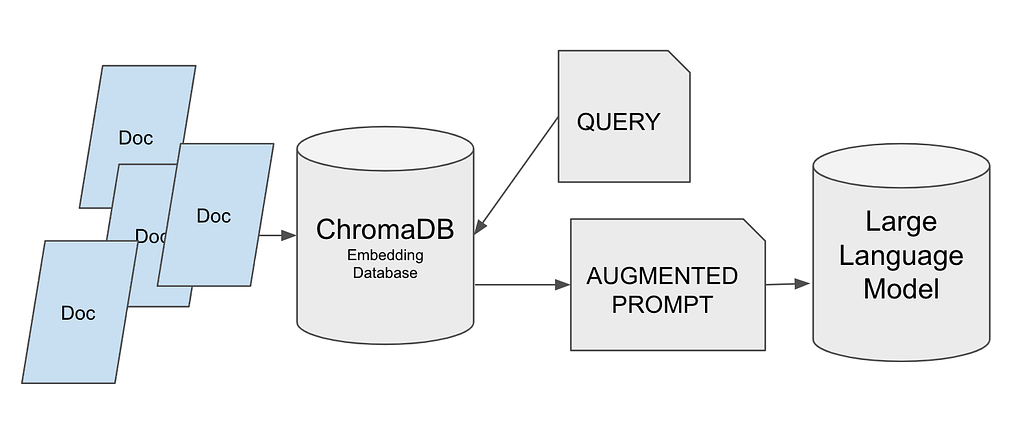

In [ ]:
!pip install chromadb

Декодирование текста

In [ ]:
from unstructured.staging.base import elements_from_json
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
import os
from langchain.vectorstores import Chroma

def decode_text(text):
    try:
        # Пробуем декодировать, если текст изначально закодирован
        if isinstance(text, bytes):
            return text.decode('utf-8')
        return text
    except (UnicodeDecodeError, AttributeError):
        return text

# Функция для загрузки файлов и декодирования текста
def load_processed_files(directory_path):
    elements = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            try:
                # Загружаем элементы из JSON
                file_elements = elements_from_json(filename=file_path)
                # Применяем декодирование текста для каждого элемента
                for element in file_elements:
                    if hasattr(element, "text") and element.text is not None:
                        element.text = decode_text(element.text)
                elements.extend(file_elements)
            except IOError:
                print(f"Error: Could not read file {filename}.")
    return elements

# Загружаем элементы с декодированным текстом
elements = load_processed_files(directory_with_results)


# Преобразуем элементы в объекты Document
documents = []
for element in elements:
    metadata = element.metadata.to_dict()
    documents.append(Document(page_content=element.text))

In [ ]:
documents

### Создаем векторное хранилище ChromaDB

In [ ]:
# db = Chroma.from_documents(documents, HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5"))
# retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 4})

Создадим две коллекции

Первая хранит информацию с инструкциями по уходу за ювелирными украшениями

Вторая содержит информацию о товарах - каталог

In [ ]:
import chromadb

In [ ]:
chroma_client = chromadb.PersistentClient(path="./chroma")

In [ ]:
collection_name = "support_collection"

# Получаем только имена коллекций
existing_names = [str(col) for col in chroma_client.list_collections()]

if collection_name in existing_names:
    chroma_client.delete_collection(name=collection_name)

collection = chroma_client.create_collection(name=collection_name)

In [ ]:
import codecs
from uuid import uuid4

records = []
for doc in documents:
    record = {
        "id": str(uuid4()),  # Уникальный идентификатор
        "text": doc.page_content,  # Основной текст
        "metadata": doc.metadata  # Метаданные
    }
    records.append(record)

In [ ]:
# def decode_text(text):
#     try:
#         # Пробуем декодировать, если текст изначально закодирован
#         if isinstance(text, bytes):
#             return text.decode('utf-8')
#         return text
#     except (UnicodeDecodeError, AttributeError):
#         return text

# # Применяем функцию к каждому элементу 'text' в records
# decoded_documents = [decode_text(record['text']) for record in records]

In [ ]:
ids = [record['id'] for record in records]
documents = [record['text'] for record in records]

# Исправляем метаданные
metadatas = []
for record in records:
    meta = record.get('metadata', {})  # Получаем metadata или пустой dict по умолчанию

    # Проверяем, что метаданные являются непустым словарем
    if isinstance(meta, dict) and len(meta) > 0:
        metadatas.append(meta)
    else:
        metadatas.append({"source": "auto_fixed"})  # Заглушка для невалидных данных

collection.add(
    ids=ids,
    documents=documents,
    metadatas=metadatas
)

In [ ]:
collection.add(
    ids=ids,
    documents=documents,
    metadatas=metadatas
)

In [ ]:
def query_database(collection, query_text, n_results=10):
    results = collection.query(query_texts=query_text, n_results=n_results)
    return results

In [ ]:
question = 'Как ухаживать за золотыми изделиями?'

In [ ]:
answer = query_database(collection, [question], 20)

In [ ]:
answer

Создадим вторую коллекцию - каталог

In [ ]:
collection_catalog = chroma_client.create_collection(name='catalog-collection')

In [ ]:
# Пример загрузки каталога
with open("catalog.json", "r", encoding="utf-8") as f:
    catalog = json.load(f)

In [ ]:
import chromadb
from uuid import uuid4


# Преобразуем каждый элемент каталога в нужный формат для добавления в коллекцию
records = []
for item in catalog:
    record = {
        "id": str(uuid4()),  # Уникальный идентификатор для каждого товара
        "text": f"{item['name']} - {item['description']} Цена: {item['price']} URL: {item['url']}",  # Составляем текст для поиска
        "metadata": {
            "name": item['name'],
            "description": item['description'],
            "usage": item['usage'],
            "price": item['price'],
            "url": item['url']
        }  # Храним метаданные для каждого товара
    }
    records.append(record)

# Извлекаем ids, text и metadata из записей
ids = [record['id'] for record in records]
documents = [record['text'] for record in records]
metadatas = [record['metadata'] for record in records]

# Добавление документов в коллекцию
collection_catalog.add(
    ids=ids,
    documents=documents,
    metadatas=metadatas  # Добавляем метаданные для каждого товара
)

print("Документы успешно добавлены в коллекцию.")


In [ ]:
metadatas

Функция для поиска текста в коллекциях

In [ ]:
def extract(query):
  products =  query_database(collection_catalog, [query], 2)
  context =  query_database(collection, [query], 20)
  return products['documents'], context['documents']

In [ ]:
products, context = extract('Привет! Мне нужно кольцо')

In [ ]:
products

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "IlyaGusev/saiga_llama3_8b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import LLMChain

# Пайплайн для генерации текста
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")  # Замените на нужный id
]

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
    eos_token_id=terminators,
)

# Создание LLM через HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# Шаблон для формирования запроса
prompt_template = """
<|start_header_id|>user<|end_header_id|>
Ты — умный ассистент, специализирующийся на ювелирных украшениях.
Ваши основные задачи:
1. Отвечать на вопросы о ювелирных украшениях, их характеристиках и ценах по следующему контексту {context}
2. Помогать клиентам в выборе подходящих товаров по следующему контексту {products}

Ваша цель — предоставлять полезные, понятные и дружелюбные ответы.
Если вы не знаете ответа, просто скажите: «Я не знаю». Не придумывайте информацию.
При предложении товаров старайтесь быть конкретным и описывать, как товар может помочь.
Если для ответа требуется больше информации, задавайте уточняющие вопросы.

Вопрос: {question}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

# Создаем PromptTemplate
prompt = PromptTemplate(
    input_variables=["context", "products", "question"],
    template=prompt_template,
)

# Пример запроса пользователя
user_query = "Как выбрать кольцо с бриллиантом?"
products, context = extract(user_query)

# Создание LLMChain
llm_chain = LLMChain(
    llm=llm,
    prompt=prompt,
    output_parser=StrOutputParser()
)

# Создание словаря для передачи в цепочку
input_data = {
    "context": context,  # Передаем контекст
    "products": products,  # Передаем список товаров
    "question": user_query,  # Передаем сам запрос
}

# Запуск цепочки
response = llm_chain.run(input_data)
print(response)  # Выводим ответ


**Преимущества:**


**Управление метаданными:** Позволяет связывать вектора с дополнительными данными (например, текстами, контекстом), что делает её удобной для приложений NLP.

**Простота интеграции:** Простая установка и интеграция с популярными библиотеками, такими как LangChain.

**Легковесность:** Подходит для небольших и средних проектов, где нужно сочетание управления векторами и метаданными.

**Поддержка RAG:** Идеально подходит для работы с системами, где нужно извлечение данных на основе запросов.


**Недостатки:**


**Ограниченная производительность:** На больших наборах данных производительность уступает FAISS.

**Специализация:** ChromaDB лучше всего подходит для задач, связанных с RAG, и может быть менее универсальна для других сценариев.

### Повторное использование базы данных

In [ ]:
import chromadb

# Инициализация клиента с тем же путем для загрузки сохраненной базы данных
chroma_client_ = chromadb.PersistentClient(path="./chroma")

# Название коллекции, которую вы хотите загрузить
collection_name = "catalog-collection"
# collection_name = "support_collection"

# Проверка, существует ли коллекция и загрузка ее
if collection_name in [col.name for col in chroma_client_.list_collections()]:
    collection = chroma_client_.get_collection(name=collection_name)
    print(f"Коллекция '{collection_name}' успешно загружена.")
else:
    print(f"Коллекция '{collection_name}' не найдена.")
    collection = None


In [ ]:
collection.get()

### Чтение данных из БД

In [ ]:
collection

In [ ]:
# Предполагаем, что коллекция успешно загружена
if collection is not None:
    # Получаем все данные из коллекции
    results = collection.get()

    # Результаты содержат документы и метаданные
    documents = results['documents']  # Это список всех текстов/документов в коллекции

    print("Все документы из коллекции:")
    for doc in documents:
        print(doc)
else:
    print("Коллекция не найдена.")


In [ ]:
# Предполагаем, что коллекция успешно загружена
if collection_catalog is not None:
    # Получаем все данные из коллекции
    results = collection_catalog.get()

    # Результаты содержат документы и метаданные
    documents = results['documents']  # Это список всех текстов/документов в коллекции

    print("Все документы из коллекции:")
    for doc in documents:
        print(doc)
else:
    print("Коллекция не найдена.")


## Длительный поиск?

In [ ]:
!pip install -q faiss-cpu==1.8.0

In [ ]:
import faiss
from sentence_transformers import SentenceTransformer
import time
import json

In [ ]:
def init_cache():
    index = faiss.IndexFlatL2(768)
    if index.is_trained:
        print("Index trained")

    # Sentence Transformer model
    encoder = SentenceTransformer("all-mpnet-base-v2")

    return index, encoder

In [ ]:
def retrieve_cache(json_file):
    try:
        with open(json_file, "r") as file:
            cache = json.load(file)
    except FileNotFoundError:
        cache = {"questions": [], "embeddings": [], "answers": [], "response_text": []}

    return cache

In [ ]:
def store_cache(json_file, cache):
    with open(json_file, "w") as file:
        json.dump(cache, file)

In [ ]:
class semantic_cache:
    def __init__(self, json_file="cache_file.json", collection = collection, thresold=0.35, max_response=100, eviction_policy=None):
        """Инициализируем семантический кэш.

        Args:
        json_file (str): Имя файла JSON, в котором хранится кэш.
        thresold (float): Пороговое значение евклидова расстояния для определения схожести вопросов.
        max_response (int): Максимальное количество ответов, которое может хранить кэш.
        eviction_policy (str): Политика вытеснения элементов из кэша.
                                Это может быть любая политика,например, 'FIFO' (First In First Out).
                                Если None, то политика выселения применяться не будет.
        """

        # Инициализация Faiss index with Euclidean distance
        self.index, self.encoder = init_cache()

        # Установите пороговое значение евклидова расстояния
        # расстояние, равное 0, означает, что предложения идентичны
        # Мы возвращаем только предложения из кэша ниже этого порогового значении
        self.euclidean_threshold = thresold
        self.collection = collection
        self.json_file = json_file
        self.cache = retrieve_cache(self.json_file)
        self.max_response = max_response
        self.eviction_policy = eviction_policy

    def evict(self):
        """Evicts an item from the cache based on the eviction policy."""
        if self.eviction_policy and len(self.cache["questions"]) > self.max_size:
            for _ in range((len(self.cache["questions"]) - self.max_response)):
                if self.eviction_policy == "FIFO":
                    self.cache["questions"].pop(0)
                    self.cache["embeddings"].pop(0)
                    self.cache["answers"].pop(0)
                    self.cache["response_text"].pop(0)

    def ask(self, question: str) -> str:

        start_time = time.time()
        try:
            embedding = self.encoder.encode([question])

            self.index.nprobe = 8
            D, I = self.index.search(embedding, 1)

            if D[0] >= 0:
                if I[0][0] >= 0 and D[0][0] <= self.euclidean_threshold:
                    row_id = int(I[0][0])

                    print("Answer recovered from Cache. ")
                    print(f"{D[0][0]:.3f} smaller than {self.euclidean_threshold}")
                    print(f"Found cache in row: {row_id} with score {D[0][0]:.3f}")
                    print(f"response_text: " + self.cache["response_text"][row_id])

                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    print(f"Time taken: {elapsed_time:.3f} seconds")
                    return self.cache["response_text"][row_id]


            answer = query_database(collection, [question], 1)
            response_text = answer["documents"][0][0]

            self.cache["questions"].append(question)
            self.cache["embeddings"].append(embedding[0].tolist())
            self.cache["answers"].append(answer)
            self.cache["response_text"].append(response_text)

            print("Answer recovered from ChromaDB. ")
            print(f"response_text: {response_text}")

            self.index.add(embedding)

            self.evict()

            store_cache(self.json_file, self.cache)

            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time taken: {elapsed_time:.3f} seconds")

            return response_text
        except Exception as e:
            raise RuntimeError(f"Error during 'ask' method: {e}")

In [ ]:
def query_database(collection, query_text, n_results=10):
    results = collection.query(query_texts=query_text, n_results=n_results)
    return results

In [ ]:
# Инициализация кэша
cache = semantic_cache("cache.json")

In [ ]:
results = cache.ask("Привет! Как ухаживать за сережками?")

In [ ]:
results